### Initial settings

In [1]:
#-- Import general libraries
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices # Comment out this line if runing on GPU cluster
import numpy as np 
import pandas as pd
import time 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc

import wandb

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{3}"

In [3]:
# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(f"Is GPU available? {is_gpu}")

# If GPU is available, print additional information
if is_gpu:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"GPU Device Name: {device_name}")
    print(f"GPU Device Index: {current_device}")

Is GPU available? True
GPU Device Name: GeForce RTX 2080 Ti
GPU Device Index: 0


#### Filters

In [4]:
# # # ################################### # # #
# # # ######   Numerial parameters ###### # # #
# # # ################################### # # #
c = 1  # speed of sound 1m/s
courant_number = 0.1

# # # ################################### # # #
# # # ######    Linear Filter      ###### # # #
# # # ################################### # # #




filter = torch.tensor([[0.0, -1.0, 0.0],
       [-1.0, 4.0, -1.0],
       [0.0, -1.0, 0.0]])



advection_operator_x = torch.tensor([[0.0, 0.0, 0.0],
       [0.5, 0.0, -0.5],
       [0.0, 0.0, 0.0]])

advection_operator_y = torch.tensor([[0.0, -0.5, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.5, 0.0]])

print(filter)
print(filter.shape)

tensor([[ 0., -1.,  0.],
        [-1.,  4., -1.],
        [ 0., -1.,  0.]])
torch.Size([3, 3])


##### 7*7 Cubic

In [5]:
# 7*7
data_str = """-1.0975826519729831E-003   6.6388197653750505E-003  -3.1874333451830800E-002   4.1414859580519367E-003  -3.1874333451830786E-002   6.6388197653750435E-003  -1.0975826519729816E-003
 6.6388197653750505E-003  -3.4553857092072565E-002  0.13605581230003569       0.18684678279416977       0.13605581230003563       -3.4553857092072537E-002   6.6388197653750418E-003
-3.1874333451830800E-002  0.13605581230003572      -0.35093761109136207       -2.0260398151439736      -0.35093761109136201       0.13605581230003563       -3.1874333451830779E-002
 4.1414859580518951E-003  0.18684678279416983       -2.0260398151439745        8.0000000000000000       -2.0260398151439745       0.18684678279416983        4.1414859580518951E-003
-3.1874333451830786E-002  0.13605581230003563      -0.35093761109136201       -2.0260398151439736      -0.35093761109136201       0.13605581230003569       -3.1874333451830800E-002
 6.6388197653750418E-003  -3.4553857092072537E-002  0.13605581230003563       0.18684678279416977       0.13605581230003566       -3.4553857092072565E-002   6.6388197653750505E-003
-1.0975826519729816E-003   6.6388197653750435E-003  -3.1874333451830779E-002   4.1414859580519367E-003  -3.1874333451830807E-002   6.6388197653750505E-003  -1.0975826519729831E-003"""

# Convert the string to a 2D NumPy array
data_array = np.array([list(map(float, line.split())) for line in data_str.split('\n')])

# Reshape the array into a 9x9 tensor
tensor = data_array.reshape(7, 7)

# Print the generated tensor
print(tensor)

filter = torch.FloatTensor(tensor*1)

print(filter.shape)

[[-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 4.14148596e-03  1.86846783e-01 -2.02603982e+00  8.00000000e+00
  -2.02603982e+00  1.86846783e-01  4.14148596e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]]
torch.Size([7, 7])


### Define NN Model

#### one time step - skipping layers

In [6]:
# class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
#     def __init__(self, xysize, filter_weight):
#         super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

#         # Specify the size of the input (batch_size, channels, height, width)
#         in_channels = 1

#         # Specify the size of the filter/kernel
#         kernel_size = filter_weight.shape[2]
#         padding = (kernel_size - 1) // 2

#         # Create a Conv2d layer with the specified weight, input size, and padding
#         self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
#         self.conv_layer.weight.data = filter_weight

#         self.xysize = xysize

#     def forward(self, status_tn, status_tn_1, c_value, sigma2_inv):
#         output_list = [status_tn]

#         c = torch.ones((self.xysize, self.xysize), device=device)
        
#         for i in range(c_value.shape[0]):
#             for j in range(c_value.shape[0]):
#                 ones = torch.zeros((self.xysize, self.xysize), device=device)
#                 ones[i*int(self.xysize/c_value.shape[0]):(i+1)*int(self.xysize/c_value.shape[0]), j*int(self.xysize/c_value.shape[0]):(j+1)*int(self.xysize/c_value.shape[0])] = (i+j) % 2  # Alternate between 0 and 1
#                 c += ones * c_value[i]

#         # Calculate status_tn1 based on the provided expression
#         c_status_tn = c * status_tn
#         conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
        
#         status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        
#         output_list.append(status_tn1)

#         output_stacked = torch.cat(output_list, dim=1)

#         return output_stacked

In [7]:
# class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
#     def __init__(self, xysize, filter_weight):
#         super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

#         # Specify the size of the input (batch_size, channels, height, width)
#         in_channels = 1

#         # Specify the size of the filter/kernel
#         kernel_size = filter_weight.shape[2]
#         padding = (kernel_size - 1) // 2

#         # Create a Conv2d layer with the specified weight, input size, and padding
#         self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
#         self.conv_layer.weight.data = filter_weight

#         self.xysize = xysize

#     def forward(self, status_tn, status_tn_1, c, sigma2_inv):
        
#         output_list = [status_tn]

#         # Calculate status_tn1 based on the provided expression
#         c_status_tn = c * status_tn
#         conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
        
#         status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
#         # status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (1 * 1) / 2
        
#         output_list.append(status_tn1)

#         output_stacked = torch.cat(output_list, dim=1)

#         return output_stacked

In [8]:
# for batches
class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c, sigma2_inv):
        
        output_list = [status_tn]

        # Calculate status_tn1 based on the provided expression
        c_status_tn = c * status_tn
        conv_term = self.conv_layer(c_status_tn) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c)
        
        status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        
        output_list.append(status_tn1)

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

#### multi time step - skipping layers 10 C values

In [9]:
class ConstantCValueLayer(nn.Module):
    def __init__(self, xysize):
        super(ConstantCValueLayer, self).__init__()
        self.xysize = xysize

    def forward(self, c_value):
        c_value.retain_grad()
        c = torch.full((self.xysize, self.xysize), c_value.item(), device=device, requires_grad=True)
        return c

In [10]:
class AI4WaveNeuralNetwork_Multi_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_Multi_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.constant_layer = ConstantCValueLayer(xysize)

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c_value, sigma2_inv, nsteps):
        output_list = [status_tn_1, status_tn]

        c = torch.zeros((self.xysize, self.xysize), device=device)
        for i in range(c_value.shape[0]):
            ones = torch.zeros((self.xysize, self.xysize), device=device)
            ones[i*int(self.xysize/c_value.shape[0]):(i+1)*int(self.xysize/c_value.shape[0])] = 1
            c += ones * c_value[i]

        for i in range(nsteps):
            # Calculate status_tn1 based on the provided expression
            c_status_tn = c * status_tn
            conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
            
            status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
            
            output_list.append(status_tn1)

            status_tn_1 = status_tn
            status_tn = status_tn1

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

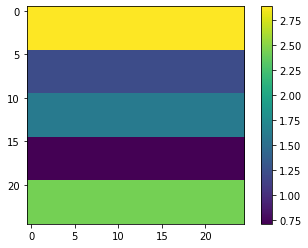

In [11]:
a = 0.5  # lower bound
b = 3  # upper bound
vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float64, device=device)

c = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)

for i in range(5):
    ones = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)
    ones[i*5:(i+1)*5] = 1
    c += ones * vec[i]


plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

In [12]:
# Get a dictionary of all variables in your program
all_vars = {name: var for name, var in locals().items() if torch.is_tensor(var)}

# Filter this dictionary to only include CUDA tensors
cuda_vars = {name: var for name, var in all_vars.items() if var.is_cuda}

# Print the names and sizes of all CUDA tensors
for name, var in cuda_vars.items():
    print(f"{name}: {var.size()}")

c: torch.Size([25, 25])
vec: torch.Size([5])
ones: torch.Size([25, 25])


In [13]:
del ones

torch.cuda.empty_cache()

gc.collect()

5600

In [14]:
del c

torch.cuda.empty_cache()

gc.collect()

0

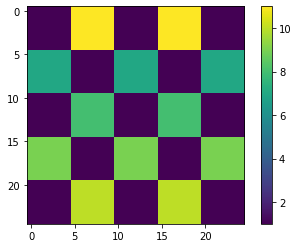

In [15]:
a = 0.5  # lower bound
b = 3  # upper bound
# vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float64, device=device)
vec = [10, 6, 7, 8, 9]

c = torch.ones((25, 25), device='cuda:0', dtype=torch.float64)

for i in range(5):
    for j in range(5):
        ones = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)
        ones[i*5:(i+1)*5, j*5:(j+1)*5] = (i+j) % 2  # Alternate between 0 and 1
        c += ones * vec[i]

plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

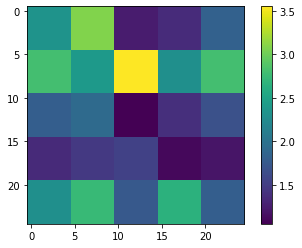

In [16]:
torch.manual_seed(0)  # Set the seed

a = 0.5  # lower bound
b = 3  # upper bound
vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float64, device=device)

c = torch.ones((25, 25), device='cuda:0', dtype=torch.float64)

for i in range(5):
    for j in range(5):
        ones = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)
        ones[i*5:(i+1)*5, j*5:(j+1)*5] = torch.rand(1).item()  # Assign a random value
        c += ones * vec[i]

plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

### Define functions to form C values

In [17]:
xysize = 300
sigma2 = 0

#### Checkerboard

In [18]:
def create_simple_checkerboard(c_values_tensor):
    c = torch.ones((xysize, xysize), device=device)
        
    for i in range(c_values_tensor.shape[0]):
        for j in range(c_values_tensor.shape[0]):
            ones = torch.zeros((xysize, xysize), device=device)
            ones[i*int(xysize/c_values_tensor.shape[0]):(i+1)*int(xysize/c_values_tensor.shape[0]), j*int(xysize/c_values_tensor.shape[0]):(j+1)*int(xysize/c_values_tensor.shape[0])] = (i+j) % 2  # Alternate between 0 and 1
            c += ones * c_values_tensor[i]
    
    return c

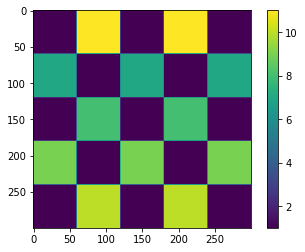

In [19]:
C_tensors_list = [10, 6, 7, 8, 9]
c_tensor = torch.tensor(C_tensors_list, dtype=torch.float32, device=device, requires_grad=True)
c = create_simple_checkerboard(c_tensor)
plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

tensor([5., 7., 5., 5., 6., 1., 9., 3., 3., 4., 6., 2., 5., 6., 9., 7., 5., 6.,
        6., 5., 4., 7., 9., 2., 9.], device='cuda:0', requires_grad=True)


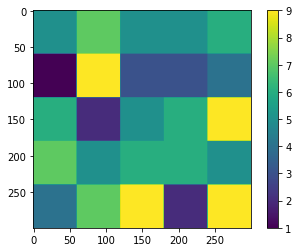

In [20]:
# number_rows = 5
# number_cols = 5
# number_all = number_rows * number_cols

# torch.manual_seed(0)  # Set the seed for reproducibility

# # c_values_tensor = torch.rand(number_all, dtype=torch.float32, device=device, requires_grad=True)
# c_values_tensor = torch.randint(low=0, high=10, size=(number_all,), device=device, dtype=torch.int)
# print(c_values_tensor)

# c = torch.zeros((xysize, xysize), device=device)  # Initialize c with zeros

# for i in range(number_rows):
#     for j in range(number_cols):
#         ones = torch.zeros((xysize, xysize), device=device)
#         ones[i*int(xysize/number_rows):(i+1)*int(xysize/number_rows), j*int(xysize/number_cols):(j+1)*int(xysize/number_cols)] = c_values_tensor[i*number_rows + j]
#         c += ones


number_rows = 5
number_cols = 5
number_all = number_rows * number_cols
torch.manual_seed(0)
c_values_tensor = torch.randint(low=1, high=10, size=(number_all,), device=device, dtype=torch.float32, requires_grad=True)

print(c_values_tensor)

def create_checkerboard(c_values_tensor, xsize, ysize, number_rows, number_cols):
    

    c = torch.zeros((xsize, ysize), device=device)  # Initialize c with zeros

    for i in range(number_rows):
        for j in range(number_cols):
            ones = torch.zeros((xsize, ysize), device=device)
            ones[i*int(xsize/number_rows):(i+1)*int(xsize/number_rows), j*int(ysize/number_cols):(j+1)*int(ysize/number_cols)] = c_values_tensor[i*number_rows + j]
            c += ones

    return c

c = create_checkerboard(c_values_tensor, xysize, xysize, number_rows, number_cols)

plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()



#### Real Data

In [21]:
# Path to the .npy file
file_path = "/home/dg321/gitTest/PRI/irp/AI4Multiphase/Data_Haifa/velocity.npy"

# Load the data
data = np.load(file_path)

print(data.shape)

(3001, 2194)


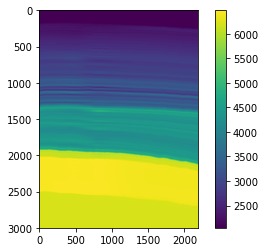

In [22]:
plt.imshow(data)
plt.colorbar()

In [23]:
xysize = 600

In [24]:
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

# Resize the data
resized_data = resize(data, (xysize, xysize))

# Scale the values between 5 and 15
scaler = MinMaxScaler(feature_range=(15, 25))
scaled_data = scaler.fit_transform(resized_data.reshape(-1, 1))

# Reshape the data back to the original shape
scaled_data = scaled_data.reshape(xysize, xysize)

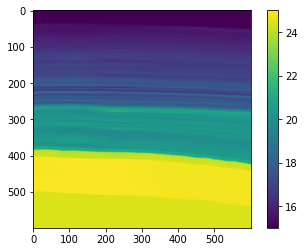

In [25]:
plt.imshow(scaled_data)
plt.colorbar()

In [26]:
def create_c_field(requires_grad):
    c = torch.tensor(scaled_data, device=device, dtype=torch.float32, requires_grad=requires_grad)
    return c

In [27]:
def create_c_field_likereal(initial_value, requires_grad):
    scaled_data_tensor = torch.tensor(scaled_data, device=device, dtype=torch.float32)
    c = initial_value * torch.ones_like(scaled_data_tensor, device=device, dtype=torch.float32, requires_grad=requires_grad)
    return c

### Data assimilation one timestep - skipping layers

#### Generate Obs

##### create initial step

In [28]:
device = torch.device('cpu')

/home/dg321/anaconda3/envs/icdss/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


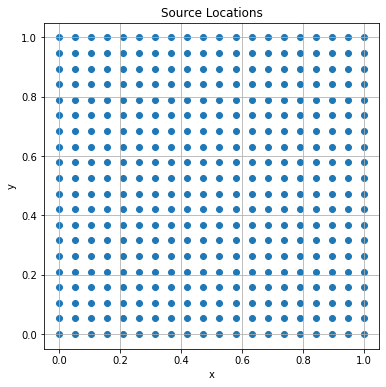

torch.Size([400, 1, 600, 600])


In [29]:
# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y, peak_value=1.0):
    result = torch.zeros_like(x)
    for mx, my in zip(mu_x, mu_y):
        exponent = -((x - mx)**2 / (2 * sigma_x**2) + (y - my)**2 / (2 * sigma_y**2))
        gauss = torch.exp(exponent)
        result += gauss / gauss.max()
    return result * peak_value

def create_and_plot_gaussians(mu_x, mu_y, sigma_x, sigma_y, peak_value, x_tensor, y_tensor):
    t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y, peak_value)
    t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y, peak_value) * torch.cos(time_tensor_t1)

    # Plot the tensors
    # plt.figure(figsize=(18, 6))

    # # Plot at t = 0
    # plt.subplot(1, 2, 1)
    # plt.imshow(t0_values.numpy(), cmap='viridis', interpolation='none')
    # plt.title('Tensor at t = 0')
    # plt.colorbar()

    # # Plot at t = 1
    # plt.subplot(1, 2, 2)
    # plt.imshow(t1_values.numpy(), cmap='viridis', interpolation='none')
    # plt.title('Tensor at t = 1')
    # plt.colorbar()

    # plt.show()

    return t0_values.view(1, 1, xysize, xysize).to(device), t1_values.view(1, 1, xysize, xysize).to(device)

# Create a meshgrid
xysize = xysize
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Parameters for Gaussian distributions
sigma_x = 0.005
sigma_y = 0.005
peak_value=1.0

# # Define the mu_x and mu_y values for the five points
# mu_x = torch.tensor([0.05, 0.05] * 2)  # Repeat the list 7 times
# mu_y = torch.tensor([0.8, 0.9]).repeat_interleave(2)  # Repeat each element 5 times

# status_t0_tensor, status_t1_tensor = create_and_plot_gaussians(mu_x, mu_y, sigma_x, sigma_y, peak_value, x_tensor, y_tensor)

# mu_x_1 = torch.tensor([0.05, 0.05] * 2)  # Repeat the list 7 times
# mu_y_1 = torch.tensor([0.2, 0.3]).repeat_interleave(2)  # Repeat each element 5 times

# status_t0_tensor_1, status_t1_tensor_1 = create_and_plot_gaussians(mu_x_1, mu_y_1, sigma_x, sigma_y, peak_value, x_tensor, y_tensor)

# input1_3d = torch.cat((status_t1_tensor, status_t1_tensor_1), dim=0)
# input2_3d = torch.cat((status_t0_tensor, status_t0_tensor_1), dim=0)


def create_tensors(source_locations, sigma_x, sigma_y, peak_value, x_tensor, y_tensor):
    tensors_t0 = []
    tensors_t1 = []

    for mu_x, mu_y in source_locations:
        mu_x = mu_x.unsqueeze(0)  # Convert to 1D tensor
        mu_y = mu_y.unsqueeze(0)  # Convert to 1D tensor
        status_t0, status_t1 = create_and_plot_gaussians(mu_x, mu_y, sigma_x, sigma_y, peak_value, x_tensor, y_tensor)
        tensors_t0.append(status_t0)
        tensors_t1.append(status_t1)

    input1_3d = torch.cat(tensors_t1, dim=0)
    input2_3d = torch.cat(tensors_t0, dim=0)

    return input1_3d, input2_3d

# Define the source locations
# source_locations = [
#     (torch.tensor([0.05]), torch.tensor([0.9]).repeat_interleave(1)),
#     (torch.tensor([0.05]), torch.tensor([0.2]).repeat_interleave(1)),
#     # Add more source locations as needed
# ]

total_source_number = 400
batch_size = 10
batches_number = int (total_source_number / batch_size)

# source_locations = [(torch.rand(1), torch.rand(1)) for _ in range(total_source_number)]

# Calculate the number of points along each dimension
points_per_dim = math.isqrt(total_source_number)

# Generate evenly spaced points along each dimension
x_coords = torch.linspace(0, 1, points_per_dim)
y_coords = torch.linspace(0, 1, points_per_dim)

# Create a grid of points
x_grid, y_grid = torch.meshgrid(x_coords, y_coords)

# Flatten the grids and pair up the coordinates
source_locations = list(zip(x_grid.flatten(), y_grid.flatten()))

# Convert the source locations to numpy arrays for plotting
x_values = np.array([location[0].item() for location in source_locations])
y_values = np.array([location[1].item() for location in source_locations])

plt.figure(figsize=(6, 6))
plt.scatter(x_values, y_values)
plt.title('Source Locations')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

input1_3d, input2_3d = create_tensors(source_locations, sigma_x, sigma_y, peak_value, x_tensor, y_tensor)

print(input1_3d.shape)

In [30]:
# Get a dictionary of all variables in your program
all_vars = {name: var for name, var in locals().items() if torch.is_tensor(var)}

# Filter this dictionary to only include CUDA tensors
cuda_vars = {name: var for name, var in all_vars.items() if var.is_cuda}

# Print the names and sizes of all CUDA tensors
for name, var in cuda_vars.items():
    print(f"{name}: {var.size()}")

vec: torch.Size([5])
var: torch.Size([25, 25])
c: torch.Size([300, 300])
ones: torch.Size([25, 25])
c_tensor: torch.Size([5])
c_values_tensor: torch.Size([25])


In [31]:
# Split the tensors into 10 batches
input1_3d_batches = torch.chunk(input1_3d, batches_number)
input2_3d_batches = torch.chunk(input2_3d, batches_number)

In [32]:
# Get a dictionary of all variables in your program
all_vars = {name: var for name, var in locals().items() if torch.is_tensor(var)}

# Filter this dictionary to only include CUDA tensors
cuda_vars = {name: var for name, var in all_vars.items() if var.is_cuda}

# Print the names and sizes of all CUDA tensors
for name, var in cuda_vars.items():
    print(f"{name}: {var.size()}")

vec: torch.Size([5])
var: torch.Size([25])
c: torch.Size([300, 300])
ones: torch.Size([25, 25])
c_tensor: torch.Size([5])
c_values_tensor: torch.Size([25])


In [33]:
del input1_3d, input2_3d, var, c

torch.cuda.empty_cache()

gc.collect()

3066

In [34]:
del vec, ones, c_tensor, c_values_tensor

torch.cuda.empty_cache()

gc.collect()

0

In [35]:
del x, y, 

torch.cuda.empty_cache()

gc.collect()

0

In [36]:
# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y, peak_value=1.0):
    # assert len(mu_x) == len(mu_y), "mu_x and mu_y must have the same length"
    result = torch.zeros_like(x)
    for mx, my in zip(mu_x, mu_y):
        exponent = -((x - mx)**2 / (2 * sigma_x**2) + (y - my)**2 / (2 * sigma_y**2))
        gauss = torch.exp(exponent)
        result += gauss / gauss.max()
    return result * peak_value

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Parameters for Gaussian distributions
sigma_x = 0.005
sigma_y = 0.005

peak_value=1.0

# Define the mu_x and mu_y values for the five points
# mu_x = [0.10, 0.25, 0.5, 0.75, 0.90, 0.10, 0.25, 0.5, 0.75, 0.90, 0.10, 0.25, 0.5, 0.75, 0.90, 0.10, 0.25, 0.5, 0.75, 0.90, 0.10, 0.25, 0.5, 0.75, 0.90, 0.10, 0.25, 0.5, 0.75, 0.90, 0.10, 0.25, 0.5, 0.75, 0.90]
# mu_y = [0.95, 0.95, 0.95, 0.95, 0.95, 0.80, 0.80, 0.80, 0.80, 0.80, 0.65, 0.65, 0.65, 0.65, 0.65, 0.35, 0.35, 0.35, 0.35, 0.35, 0.5, 0.5, 0.5, 0.5, 0.5, 0.15, 0.15, 0.15, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05]

# Define the mu_x and mu_y values for the five points
# mu_x = torch.tensor([0.05, 0.10, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 0.90, 0.95] * 13)  # Repeat the list 7 times
# mu_y = torch.tensor([0.95, 0.80, 0.65, 0.35, 0.5, 0.4, 0.3, 0.2, 0.15, 0.10, 0.05, 0.01, 0]).repeat_interleave(10)  # Repeat each element 5 times
mu_x = torch.tensor([0.05, 0.05] * 2)  # Repeat the list 7 times
mu_y = torch.tensor([0.8, 0.9]).repeat_interleave(2)  # Repeat each element 5 times

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y, peak_value)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y, peak_value) * torch.cos(time_tensor_t1)

In [37]:
# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Parameters for Gaussian distributions
sigma_x = 0.005
sigma_y = 0.005

peak_value=1.0

# Define the mu_x and mu_y values for the five points
mu_x_1 = torch.tensor([0.05, 0.05] * 2)  # Repeat the list 7 times
mu_y_1 = torch.tensor([0.2, 0.3]).repeat_interleave(2)  # Repeat each element 5 times

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values_1 = gaussian2d(x_tensor, y_tensor, mu_x_1, mu_y_1, sigma_x, sigma_y, peak_value)
t1_values_1 = gaussian2d(x_tensor, y_tensor, mu_x_1, mu_y_1, sigma_x, sigma_y, peak_value) * torch.cos(time_tensor_t1)



In [38]:
# # Function to create 2D Gaussian distribution
# def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
#     # assert len(mu_x) == len(mu_y), "mu_x and mu_y must have the same length"
#     result = torch.zeros_like(x)
#     for mx, my in zip(mu_x, mu_y):
#         exponent = -((x - mx)**2 / (2 * sigma_x**2) + (y - my)**2 / (2 * sigma_y**2))
#         result += torch.exp(exponent)
#     return result

# # Parameters for Gaussian distributions
# sigma_x = 0.005
# sigma_y = 0.005

# # # Define the mu_x and mu_y values for the four points
# # mu_x = [0.25, 0.75, 0.25, 0.75]
# # mu_y = [0.25, 0.25, 0.75, 0.75]

# # # Evaluate the Gaussian distributions at t = 0, 1, and 2
# # t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
# # t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# # Define the mu_x and mu_y values for the eight points
# mu_x = [0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.125, 0.875]
# mu_y = [0.25, 0.25, 0.75, 0.75, 0.125, 0.875, 0.5, 0.5]

# # Evaluate the Gaussian distributions at t = 0, 1, and 2
# t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
# t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

In [39]:
# # Function to create 2D Gaussian distribution
# def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
#     assert len(mu_x) == len(mu_y) == len(sigma_x) == len(sigma_y), "All input lists must have the same length"
#     result = torch.zeros_like(x)
#     for mx, my, sx, sy in zip(mu_x, mu_y, sigma_x, sigma_y):
#         exponent = -((x - mx)**2 / (2 * sx**2) + (y - my)**2 / (2 * sy**2))
#         result += torch.exp(exponent)
#     return result

# # Define the mu_x, mu_y, sigma_x, and sigma_y values for the eight points
# mu_x = [0.25, 0.75, 0.25, 0.75, 0.5]
# mu_y = [0.25, 0.25, 0.75, 0.75, 0.125]
# sigma_x = [0.005, 0.005, 0.005, 0.005, 0.005]
# sigma_y = [0.005, 0.005, 0.005, 0.005, 0.005]

# # Evaluate the Gaussian distributions at t = 0, 1, and 2
# t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
# t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

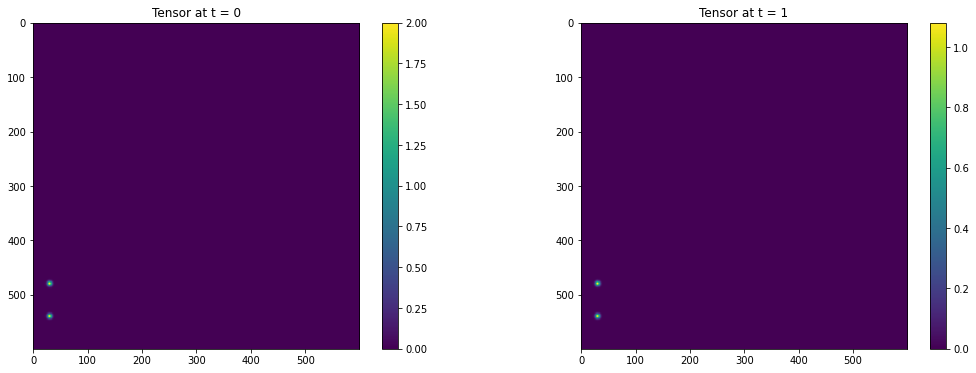

In [38]:
# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Plot the tensors
plt.figure(figsize=(18, 6))

# Plot at t = 0
plt.subplot(1, 2, 1)
plt.imshow(status_t0.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 0')
plt.colorbar()

# Plot at t = 1
plt.subplot(1, 2, 2)
plt.imshow(status_t1.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 1')
plt.colorbar()

# # Plot at t = 2
# plt.subplot(1, 3, 3)
# plt.imshow(status_t2.numpy(), cmap='viridis', interpolation='none')
# plt.title('Tensor at t = 2')
# plt.colorbar()

plt.show()

In [27]:
# Stack the tensors along a new dimension to create 3D tensors
status_t0_1 = t0_values_1
status_t1_1 = t1_values_1

# Plot the tensors
plt.figure(figsize=(18, 6))

# Plot at t = 0
plt.subplot(1, 2, 1)
plt.imshow(status_t0_1.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 0')
plt.colorbar()

# Plot at t = 1
plt.subplot(1, 2, 2)
plt.imshow(status_t1_1.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 1')
plt.colorbar()

# # Plot at t = 2
# plt.subplot(1, 3, 3)
# plt.imshow(status_t2.numpy(), cmap='viridis', interpolation='none')
# plt.title('Tensor at t = 2')
# plt.colorbar()

plt.show()

NameError: name 't0_values_1' is not defined

In [42]:
## Using bigger model - multi time steps
# # Specify the size of the tensor
# xysize = 125
# mu_x = 0.2   # 0.5
# mu_y = 0.2  # 0.5

# timesteps = 10    # 300

# # C values
# C_values_list = [5, 6, 7, 8, 9]
# # C_values_list = [1, 1, 1, 1, 1]
# c_tensor = torch.tensor(C_values_list, dtype=torch.float32, device=device, requires_grad=True)

# nlayers = c_tensor.size(0)

# # Plot C
# c = torch.zeros((xysize, xysize), device=device, dtype=torch.float32)

# for i in range(nlayers):
#     ones = torch.zeros((xysize, xysize), device=device, dtype=torch.float32)
#     ones[i*int(xysize/nlayers):(i+1)*int(xysize/nlayers)] = 1
#     c += ones * c_tensor[i]

# plt.imshow(c.cpu().detach().numpy(), cmap='viridis')
# plt.colorbar()
# plt.title('C Values - Ground Truth')
# plt.show()

# # Create a meshgrid
# x_values = np.linspace(0, 1, xysize)
# y_values = np.linspace(0, 1, xysize)
# x, y = np.meshgrid(x_values, y_values)

# # Convert NumPy arrays to PyTorch tensors with float type
# x_tensor = torch.tensor(x, dtype=torch.float32)
# y_tensor = torch.tensor(y, dtype=torch.float32)

# # Equation parameters
# sqrt2 = np.sqrt(2)
# pi = np.pi

# # Define the time tensors for t = 0, 1, and 2
# time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
# time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# # Function to create 2D Gaussian distribution
# def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
#     exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
#     return torch.exp(exponent)

# # Parameters for Gaussian distributions
# sigma_x = 0.005
# sigma_y = 0.005

# # Evaluate the Gaussian distributions at t = 0, 1, and 2
# t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
# t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# # Stack the tensors along a new dimension to create 3D tensors
# status_t0 = t0_values
# status_t1 = t1_values

# filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter

# mymodel_multi = AI4WaveNeuralNetwork_Multi_Skipping(xysize, filter_weight)

# status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

# # Perform a forward pass using AI4WaveNeuralNetwork
# status_t1_tensor = status_t1.view(1, 1, xysize, xysize).to(device)

# # Initial Status (t = 0)
# fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# # Plot the image on the first subplot
# im = axs[0].imshow(status_t0.cpu().detach().numpy(), cmap='viridis')
# fig.colorbar(im, ax=axs[0])
# axs[0].set_title("Initial Status (t = 0)")

# # Plot the vertical profile on the second subplot
# vertical_profile = status_t0.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
# axs[1].plot(vertical_profile)
# axs[1].set_title("Vertical profile at t = 0")

# plt.show()

# # Initial Status (t = 1)
# fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# # Plot the image on the first subplot
# im = axs[0].imshow(status_t1.cpu().detach().numpy(), cmap='viridis')
# fig.colorbar(im, ax=axs[0])
# axs[0].set_title("Initial Status (t = 1)")

# # Plot the vertical profile on the second subplot
# vertical_profile = status_t1.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
# axs[1].plot(vertical_profile)
# axs[1].set_title("Vertical profile at t = 1")

# plt.show()

# output_tensor_obs = mymodel_multi(status_t1_tensor, status_t0_tensor, c_tensor, sigma2, nsteps = timesteps)

# for i in range(timesteps):
#     if (i) % 5 == 0:
#         fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

#         # Plot the image on the first subplot
#         im = axs[0].imshow(output_tensor_obs.cpu().detach().numpy()[0][i+2], cmap='viridis')
#         fig.colorbar(im, ax=axs[0])
#         axs[0].set_title(f"Status at t = {i+2}")

#         # Plot the vertical profile on the second subplot
#         vertical_profile = output_tensor_obs.cpu().detach().numpy()[0][i+2][xysize//2, :]  # Take the middle row
#         axs[1].plot(vertical_profile)
#         axs[1].set_title(f"Vertical profile at t = {i+2}")

#         plt.show()

# print(output_tensor_obs.shape)

In [39]:
def forward_simulation_nograd(timesteps, model, input1, input2, c, sigma2):
    with torch.no_grad():
        output_list = []
        for _ in range(timesteps):
            output = model(input1, input2, c, sigma2)
            output_list.append(output[:,1:, :, :])
            input1 = output[:,1:, :, :]
            input2 = output[:,0:1, :, :]
        output_tensor = torch.cat(output_list, dim=1).squeeze(0)
    return output_tensor


def forward_simulation(timesteps, model, input1, input2, c, sigma2):
    output_list = []
    for _ in range(timesteps):
        output = model(input1, input2, c, sigma2)
        output_list.append(output[:,1:, :, :])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)
    return output_tensor

In [51]:
del x_tensor, y_tensor, t0_values, t1_values, t0_values_1, t1_values_1

torch.cuda.empty_cache()

gc.collect()

NameError: name 'x_tensor' is not defined

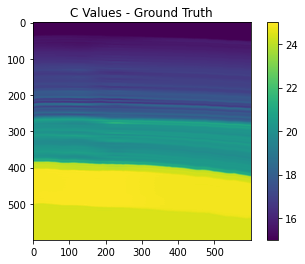

torch.Size([600, 600])
torch.Size([10, 1, 600, 600])


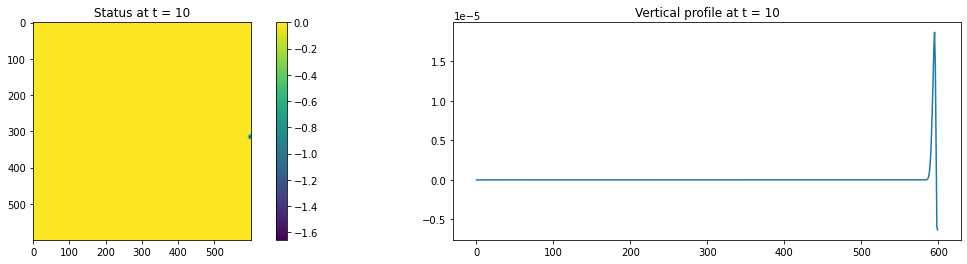

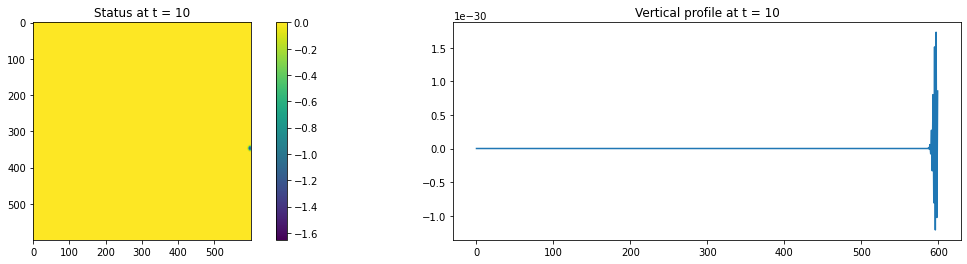

torch.Size([10, 8, 600, 600])


In [40]:
# Enable memory profiling
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()

timesteps = 8

# status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)
# status_t1_tensor = status_t1.view(1, 1, xysize, xysize).to(device)

# status_t0_tensor_1 = status_t0_1.view(1, 1, xysize, xysize).to(device)
# status_t1_tensor_1 = status_t1_1.view(1, 1, xysize, xysize).to(device)

filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)
mymodel_obs = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight).to(device)
# output_list = [status_t0_tensor, status_t1_tensor]
# input1 = status_t1_tensor
# input2 = status_t0_tensor
number_rows = 5
number_cols = 5
number_all = number_rows * number_cols
torch.manual_seed(0)
c = create_c_field(requires_grad=False)
c_show = c
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Ground Truth')
plt.show()

# for _ in range(timesteps):
#     output = mymodel_obs(input1, input2, c, sigma2)
#     output_list.append(output[:,1:, :, :])
#     input1 = output[:,1:, :, :]
#     input2 = output[:,0:1, :, :]

# output_tensor_obs = torch.cat(output_list, dim=1).squeeze(0)

# print(input1_3d.shape)
print(c.shape)

# input1_3d = torch.cat((input1, status_t1_tensor_1), dim=0)
# input2_3d = torch.cat((input2, status_t0_tensor_1), dim=0)

# print(input1_3d.shape)

# c_3d = torch.stack((c, c))
# c_3d = c_3d.view(batch_size, 1, xysize, xysize)
c_3d = c.unsqueeze(0).repeat(batch_size, 1, 1, 1)
print(c_3d.shape)





# with torch.no_grad():
#     output_list = []
#     for _ in range(timesteps):
#         output = mymodel_obs(input1_3d, input2_3d, c_3d, sigma2)
#         output_list.append(output[:,1:, :, :])
#         input1 = output[:,1:, :, :]
#         input2 = output[:,0:1, :, :]
#     output_tensor = torch.cat(output_list, dim=1).squeeze(0)


# with torch.no_grad():
#     output_tensor_obs_chunks = []
#     for input1_3d, input2_3d in zip(input1_3d_batches, input2_3d_batches):
#         output_tensor_obs = forward_simulation_nograd(timesteps, mymodel_obs, input1_3d, input2_3d, c_3d, sigma2)
#         output_tensor_obs_chunks.append(output_tensor_obs)
#     Status_List_stacked_obs = torch.cat(output_tensor_obs_chunks, dim=0)
#     Status_List_stacked_obs_batches = torch.chunk(Status_List_stacked_obs, batches_number)

# with torch.no_grad():
#     Status_List_stacked_obs = None
#     for input1_3d, input2_3d in zip(input1_3d_batches, input2_3d_batches):
#         output_tensor_obs = forward_simulation_nograd(timesteps, mymodel_obs, input1_3d, input2_3d, c_3d, sigma2)
#         if Status_List_stacked_obs is None:
#             Status_List_stacked_obs = output_tensor_obs
#         else:
#             Status_List_stacked_obs = torch.cat((Status_List_stacked_obs, output_tensor_obs), dim=0)
#         del output_tensor_obs
#         torch.cuda.empty_cache()
#         gc.collect()  # Manually call the garbage collector
#     Status_List_stacked_obs_batches = torch.chunk(Status_List_stacked_obs, batches_number)

with torch.no_grad():
    Status_List_stacked_obs_batches = []
    batch_size = len(input1_3d_batches[0])
    for input1_3d, input2_3d in zip(input1_3d_batches, input2_3d_batches):
        output_tensor_obs = forward_simulation_nograd(timesteps, mymodel_obs, input1_3d, input2_3d, c_3d, sigma2)
        Status_List_stacked_obs_batches.append(output_tensor_obs)
        del output_tensor_obs
        torch.cuda.empty_cache()
        gc.collect()  # Manually call the garbage collector

# Delete all other variables
del input1_3d, input2_3d, mymodel_obs, c, c_show
torch.cuda.empty_cache()
gc.collect()  # Manually call the garbage collector

# print(output_tensor_obs.shape)

fig, axs = plt.subplots(1, 2, figsize=(20, 4))
im = axs[0].imshow(Status_List_stacked_obs_batches[-1].cpu().detach().numpy()[0][-1], cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title(f"Status at t = {timesteps+2}")
vertical_profile = Status_List_stacked_obs_batches[-1].cpu().detach().numpy()[0][-1][xysize//2, :]
axs[1].plot(vertical_profile)
axs[1].set_title(f"Vertical profile at t = {timesteps+2}")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 4))
im = axs[0].imshow(Status_List_stacked_obs_batches[-1].cpu().detach().numpy()[1][-1], cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title(f"Status at t = {timesteps+2}")
vertical_profile = Status_List_stacked_obs_batches[-1].cpu().detach().numpy()[1][-1][xysize//2, :]
axs[1].plot(vertical_profile)
axs[1].set_title(f"Vertical profile at t = {timesteps+2}")
plt.show()

print(Status_List_stacked_obs_batches[-1].shape)


# Status_List_stacked_obs = output_tensor_obs
# print(Status_List_stacked_obs.shape)
# Status_List_stacked_obs_batches = torch.chunk(Status_List_stacked_obs, 10)



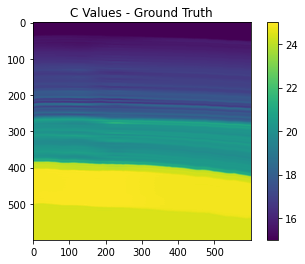

torch.Size([600, 600])
torch.Size([10, 1, 600, 600])


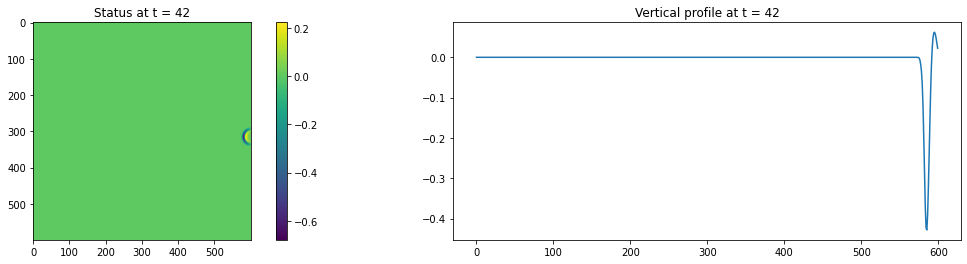

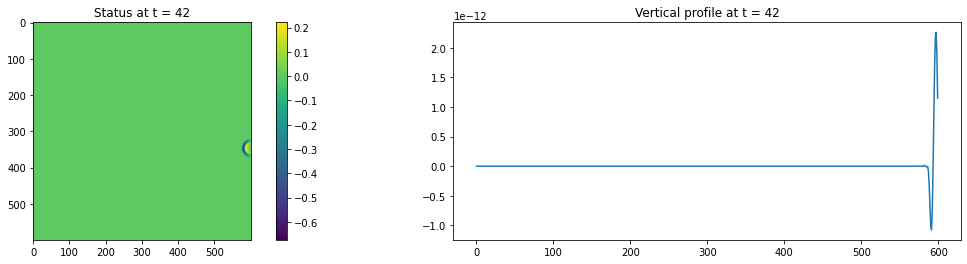

torch.Size([10, 40, 600, 600])


In [33]:
# Enable memory profiling
# torch.cuda.reset_peak_memory_stats()
# torch.cuda.reset_accumulated_memory_stats()

timesteps = 40

filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to('cpu')
mymodel_obs = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight).to('cpu')

number_rows = 5
number_cols = 5
number_all = number_rows * number_cols
torch.manual_seed(0)
c = create_c_field(requires_grad=False)
c_show = c
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Ground Truth')
plt.show()

print(c.shape)

c_3d = c.unsqueeze(0).repeat(batch_size, 1, 1, 1)
print(c_3d.shape)

with torch.no_grad():
    Status_List_stacked_obs_batches = []
    batch_size = len(input1_3d_batches[0])
    for input1_3d, input2_3d in zip(input1_3d_batches, input2_3d_batches):
        output_tensor_obs = forward_simulation_nograd(timesteps, mymodel_obs, input1_3d, input2_3d, c_3d, sigma2)
        Status_List_stacked_obs_batches.append(output_tensor_obs)
        del output_tensor_obs
        # torch.cuda.empty_cache()
        gc.collect()  # Manually call the garbage collector

# Delete all other variables
del input1_3d, input2_3d, mymodel_obs, c, c_show
# torch.cuda.empty_cache()
gc.collect()  # Manually call the garbage collector

fig, axs = plt.subplots(1, 2, figsize=(20, 4))
im = axs[0].imshow(Status_List_stacked_obs_batches[-1].cpu().detach().numpy()[0][-1], cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title(f"Status at t = {timesteps+2}")
vertical_profile = Status_List_stacked_obs_batches[-1].cpu().detach().numpy()[0][-1][xysize//2, :]
axs[1].plot(vertical_profile)
axs[1].set_title(f"Vertical profile at t = {timesteps+2}")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 4))
im = axs[0].imshow(Status_List_stacked_obs_batches[-1].cpu().detach().numpy()[1][-1], cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title(f"Status at t = {timesteps+2}")
vertical_profile = Status_List_stacked_obs_batches[-1].cpu().detach().numpy()[1][-1][xysize//2, :]
axs[1].plot(vertical_profile)
axs[1].set_title(f"Vertical profile at t = {timesteps+2}")
plt.show()

print(Status_List_stacked_obs_batches[-1].shape)

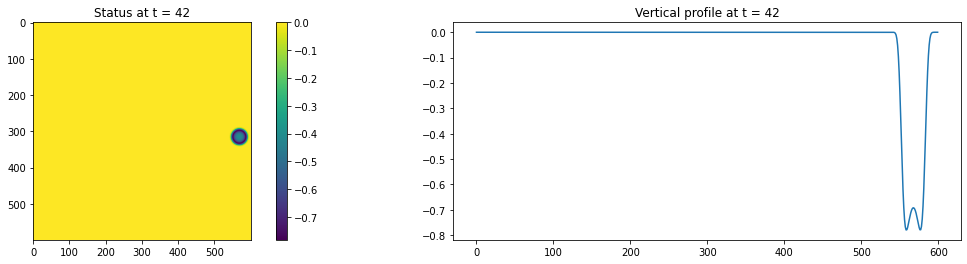

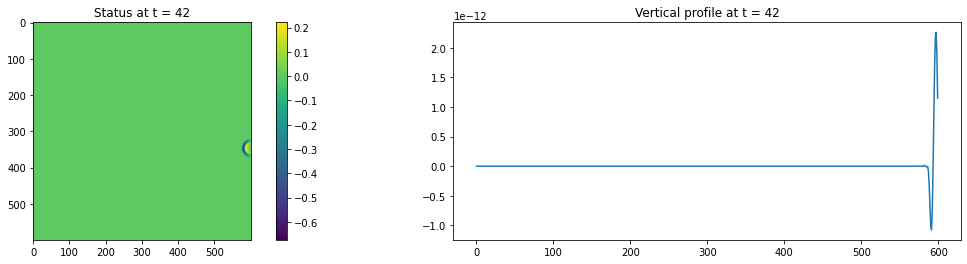

torch.Size([10, 40, 600, 600])


In [34]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
im = axs[0].imshow(Status_List_stacked_obs_batches[-3].cpu().detach().numpy()[0][-1], cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title(f"Status at t = {timesteps+2}")
vertical_profile = Status_List_stacked_obs_batches[-3].cpu().detach().numpy()[0][-1][xysize//2, :]
axs[1].plot(vertical_profile)
axs[1].set_title(f"Vertical profile at t = {timesteps+2}")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 4))
im = axs[0].imshow(Status_List_stacked_obs_batches[-1].cpu().detach().numpy()[1][-1], cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title(f"Status at t = {timesteps+2}")
vertical_profile = Status_List_stacked_obs_batches[-1].cpu().detach().numpy()[1][-1][xysize//2, :]
axs[1].plot(vertical_profile)
axs[1].set_title(f"Vertical profile at t = {timesteps+2}")
plt.show()

print(Status_List_stacked_obs_batches[-1].shape)

In [59]:
# Print memory stats
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / 1024 ** 2} MB")
print(f"Peak reserved memory: {torch.cuda.max_memory_reserved() / 1024 ** 2} MB")
print(f"Currently allocated memory: {torch.cuda.memory_allocated() / 1024 ** 2} MB")
print(f"Currently reserved memory: {torch.cuda.memory_reserved() / 1024 ** 2} MB")

Peak allocated memory: 4560.48095703125 MB
Peak reserved memory: 4636.0 MB
Currently allocated memory: 4462.748046875 MB
Currently reserved memory: 4482.0 MB


In [53]:
# Get a dictionary of all variables in your program
# all_vars = {name: var for name, var in locals().items() if torch.is_tensor(var)}
all_vars = {name: var for name, var in globals().items() if torch.is_tensor(var)}

# Filter this dictionary to only include CUDA tensors
cuda_vars = {name: var for name, var in all_vars.items() if var.is_cuda}

# Print the names and sizes of all CUDA tensors
for name, var in cuda_vars.items():
    print(f"{name}: {var.size()}")

filter_weight: torch.Size([1, 1, 7, 7])
c: torch.Size([600, 600])
c_show: torch.Size([600, 600])


In [57]:
import sys
import torch

# Get a dictionary of all variables in your program
all_vars = {name: var for name, var in locals().items()}

# Create a list of tuples containing the name, type, and memory usage of each variable
var_info = []
total_memory_usage_mb = 0
for name, var in all_vars.items():
    if torch.is_tensor(var):
        # For tensors, calculate memory usage manually
        memory_usage = var.element_size() * var.nelement()
    else:
        # For other types, use sys.getsizeof
        memory_usage = sys.getsizeof(var)
    # Convert memory usage to MB
    memory_usage_mb = memory_usage / (1024 ** 2)
    total_memory_usage_mb += memory_usage_mb
    var_info.append((name, type(var), memory_usage_mb))

# Sort the list by memory usage, in descending order
var_info.sort(key=lambda x: x[2], reverse=True)

# Print the names, types, and memory usage of all variables
for name, var_type, memory_usage in var_info:
    print(f"{name}: {var_type}, Memory usage: {memory_usage} MB")

# Print the total memory usage
print(f"Total memory usage: {total_memory_usage_mb} MB")

resized_data: <class 'numpy.ndarray'>, Memory usage: 1.3734130859375 MB
status_t0: <class 'torch.Tensor'>, Memory usage: 1.373291015625 MB
status_t1: <class 'torch.Tensor'>, Memory usage: 1.373291015625 MB
status_t0_1: <class 'torch.Tensor'>, Memory usage: 1.373291015625 MB
status_t1_1: <class 'torch.Tensor'>, Memory usage: 1.373291015625 MB
c: <class 'torch.Tensor'>, Memory usage: 1.373291015625 MB
c_show: <class 'torch.Tensor'>, Memory usage: 1.373291015625 MB
all_vars: <class 'dict'>, Memory usage: 0.008880615234375 MB
_i44: <class 'str'>, Memory usage: 0.00444793701171875 MB
_i52: <class 'str'>, Memory usage: 0.00444793701171875 MB
_i29: <class 'str'>, Memory usage: 0.004352569580078125 MB
_i42: <class 'str'>, Memory usage: 0.004088401794433594 MB
source_locations: <class 'list'>, Memory usage: 0.00336456298828125 MB
_i36: <class 'str'>, Memory usage: 0.001983642578125 MB
_i6: <class 'str'>, Memory usage: 0.0018129348754882812 MB
_i10: <class 'str'>, Memory usage: 0.001795768737792

In [42]:
number_of_chunks = len(Status_List_stacked_obs_batches)
print(number_of_chunks)

40


In [43]:
import gc
gc.collect()

13950

#### One time forward stepping

[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [599 597]
 [599 598]
 [599 599]]


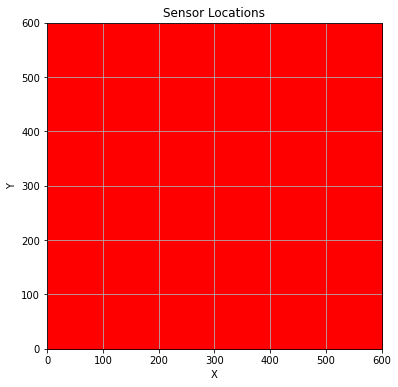

In [41]:
# Set the seed for reproducibility
np.random.seed(0)

# Define the size of your domain
domain_size = (xysize, xysize)  # Example: xysizexxysize grid

n_srata = xysize    #  5
n_sensors = n_srata * n_srata

# Define the number of strata in each dimension
strata_size = (n_srata, n_srata)  # Example: 10x10 strata

# Calculate the size of each stratum
stratum_size = (domain_size[0] // strata_size[0], domain_size[1] // strata_size[1])

# Generate random sensor locations within each stratum
sensor_indices = np.array([
    (np.random.randint(i * stratum_size[0], (i + 1) * stratum_size[0]),
     np.random.randint(j * stratum_size[1], (j + 1) * stratum_size[1]))
    for i in range(strata_size[0])
    for j in range(strata_size[1])
])

# Plot the domain
plt.figure(figsize=(6, 6))
plt.xlim(0, domain_size[0])
plt.ylim(0, domain_size[1])

print(sensor_indices)

# Plot the sensor locations
plt.scatter(sensor_indices[:, 0], sensor_indices[:, 1], color='red')

plt.title('Sensor Locations')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [42]:
# Convert sensor_indices to a PyTorch tensor
sensor_indices = torch.tensor(sensor_indices)

# Separate the x and y coordinates
x_coords = sensor_indices[:, 0]
y_coords = sensor_indices[:, 1]

# Use broadcasting to create a grid of indices
x_coords = x_coords[None, :, None]
y_coords = y_coords[None, :, None]

# Index the output and observation tensors at the sensor locations
# output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
# obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

# Now, output_at_sensors and obs_at_sensors should have the shape (302, 25)
# print(output_at_sensors.shape)
# print(obs_at_sensors.shape)

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

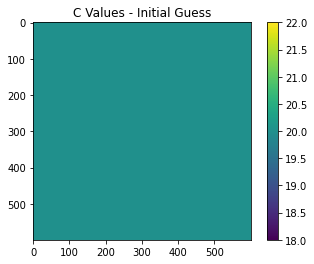

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guodh5 (guodh). Use `wandb login --relogin` to force relogin
2024-05-28 10:35:55.327200: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Exception in thread StatsThr:
Traceback (most recent call last):
  File "/home/dg321/anaconda3/envs/icdss/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/dg321/anaconda3/envs/icdss/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dg321/anaconda3/envs/icdss/lib/python3.8/site-packages/wandb/sdk/internal/stats.py", line 126, in _thread_body
    stats = self.stats()
  File "/h

epochs: 0


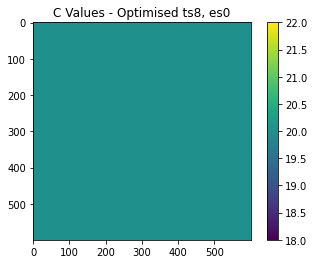

epochs: 10


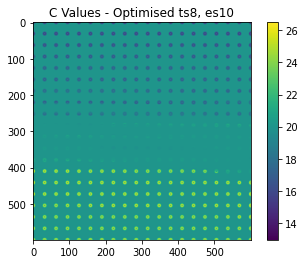

epochs: 20


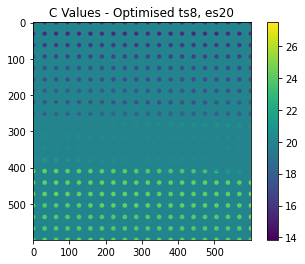

epochs: 30


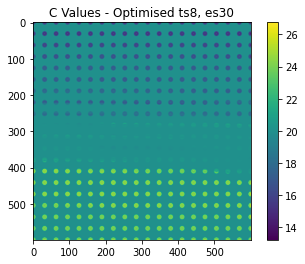

epochs: 40


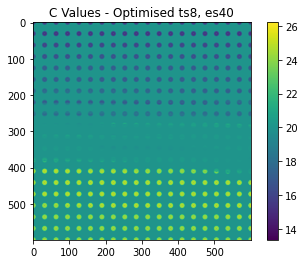

epochs: 50


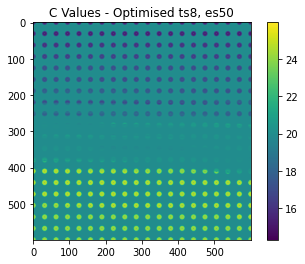

epochs: 60


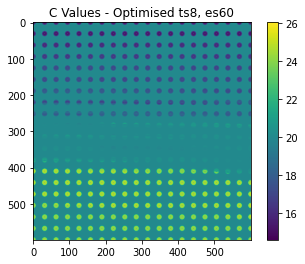

epochs: 70


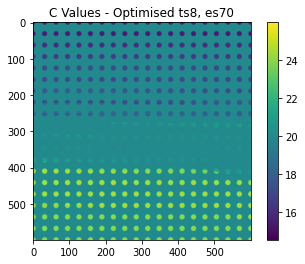

epochs: 80


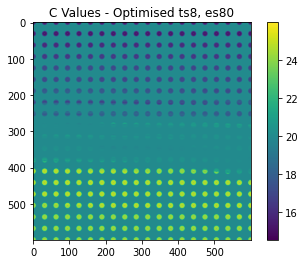

epochs: 90


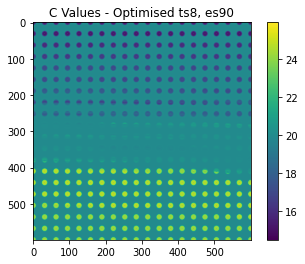

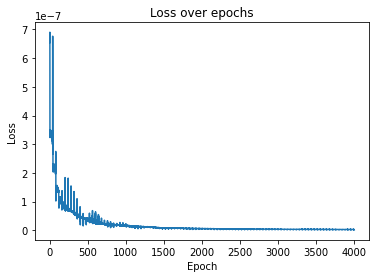

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mse_loss = nn.MSELoss()

number_rows = 80
number_cols = 80
number_all = number_rows * number_cols

C_guess_value = 20
c_forward1 = create_c_field_likereal(C_guess_value, requires_grad=False).detach().requires_grad_(True).to(device)
c_show = create_c_field_likereal(C_guess_value, requires_grad=True)

plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Initial Guess')
plt.show()

lr = 0.1

name = f"Real Data, guess {C_guess_value}s, number_rows{number_rows}, number_cols{number_cols}, timestep {timesteps} whole domain, {xysize}*{xysize}, lr{lr}, Sensors{n_sensors}, mu_x{mu_x}, mu_y{mu_y}"

run = wandb.init(project="wave eqn - checkerboard", name=name)

c_forward1_unconstrained = torch.log(c_forward1).detach().requires_grad_(True).to(device)

optimizer = torch.optim.Adam([c_forward1_unconstrained], lr)
c_values = [c_forward1.tolist()]

losses = []
epochs = 100

model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight).to(device)

for n in range(epochs):
    optimizer.zero_grad()
    if n % 10 == 0:
        print('epochs:', n)
        c_show = c_forward1
        plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
        plt.colorbar()
        plt.title(f'C Values - Optimised ts{timesteps}, es{n}')
        plt.show()
    for input1_3d, input2_3d, Obs_sensor_3d_array in zip(input1_3d_batches, input2_3d_batches, Status_List_stacked_obs_batches):
        # optimizer.zero_grad()

        c_forward1 = torch.exp(c_forward1_unconstrained)

        c = c_forward1.unsqueeze(0)
        c = c.repeat(10, 1, 1, 1)

        # Move the batches to the GPU
        input1_3d = input1_3d.to(device)
        input2_3d = input2_3d.to(device)
        c = c.to(device)
        Obs_sensor_3d_array = Obs_sensor_3d_array.to(device)

        output_tensor = forward_simulation(timesteps, model, input1_3d, input2_3d, c, sigma2)

        output_at_sensors = output_tensor
        obs_at_sensors = Obs_sensor_3d_array

        loss = mse_loss(output_at_sensors, obs_at_sensors)

        loss.backward(retain_graph=True)

        losses.append(loss.item())

        # optimizer.step()
        # c_values.append(c_forward1.tolist())

        log_dict = {"loss": loss.item()}
        log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
        wandb.log(log_dict)

        # if n % 2 == 0:
        #     print('epochs:', n)
        #     c_show = c_forward1
        #     plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
        #     plt.colorbar()
        #     plt.title(f'C Values - Optimised ts{timesteps}, es{n}')
        #     plt.show()
    
    optimizer.step()  # Update parameters after processing all batches
    c_values.append(c_forward1.tolist())

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

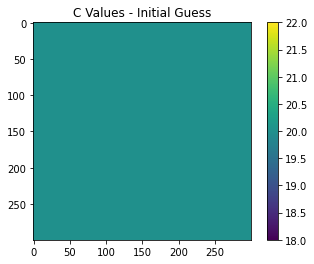

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guodh5 (guodh). Use `wandb login --relogin` to force relogin
2024-05-14 15:59:41.342616: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


epochs: 0


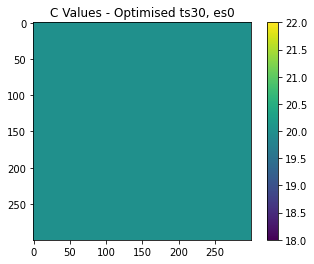

epochs: 10


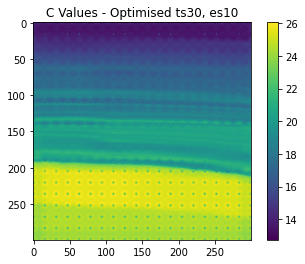

epochs: 20


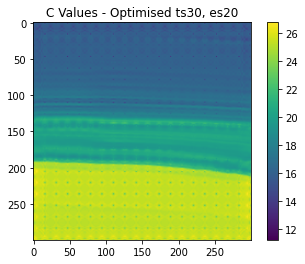

epochs: 30


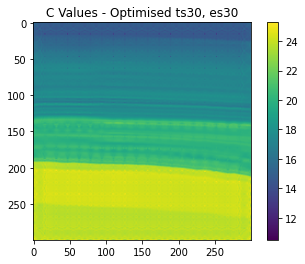

epochs: 40


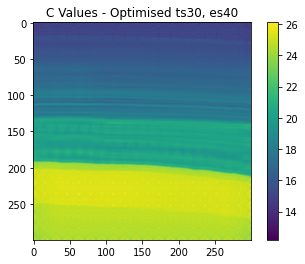

epochs: 50


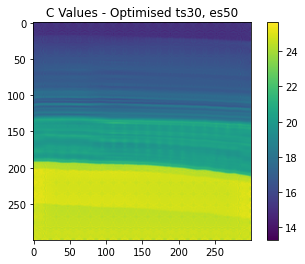

epochs: 60


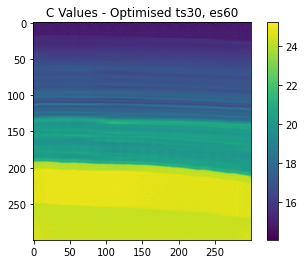

epochs: 70


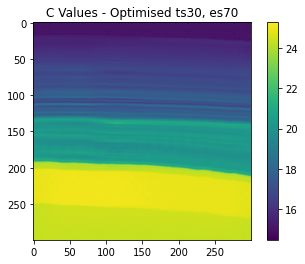

epochs: 80


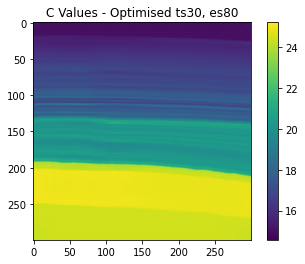

epochs: 90


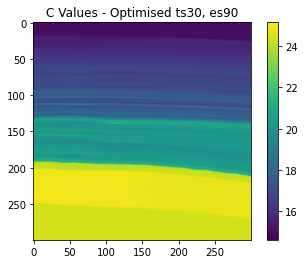

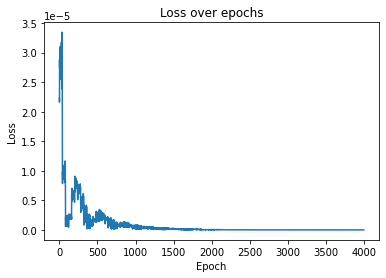

In [46]:
mse_loss = nn.MSELoss()

number_rows = 80
number_cols = 80
number_all = number_rows * number_cols

C_guess_value = 20
c_forward1 = create_c_field_likereal(C_guess_value, requires_grad=False).detach().requires_grad_(True)
c_show = create_c_field_likereal(C_guess_value, requires_grad=True)

plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Initial Guess')
plt.show()

lr = 0.1

name = f"Real Data, guess {C_guess_value}s, number_rows{number_rows}, number_cols{number_cols}, timestep {timesteps} whole domain, {xysize}*{xysize}, lr{lr}, Sensors{n_sensors}, mu_x{mu_x}, mu_y{mu_y}"

run = wandb.init(project="wave eqn - checkerboard", name=name)

c_forward1_unconstrained = torch.log(c_forward1).detach().requires_grad_(True)

optimizer = torch.optim.Adam([c_forward1_unconstrained], lr)
c_values = [c_forward1.tolist()]

losses = []
epochs = 100

model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

for n in range(epochs):
    optimizer.zero_grad()
    if n % 10 == 0:
        print('epochs:', n)
        c_show = c_forward1
        plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
        plt.colorbar()
        plt.title(f'C Values - Optimised ts{timesteps}, es{n}')
        plt.show()
    for input1_3d, input2_3d, Obs_sensor_3d_array in zip(input1_3d_batches, input2_3d_batches, Status_List_stacked_obs_batches):
        # optimizer.zero_grad()

        c_forward1 = torch.exp(c_forward1_unconstrained)

        c = c_forward1.unsqueeze(0)
        c = c.repeat(10, 1, 1, 1)

        output_tensor = forward_simulation(timesteps, model, input1_3d, input2_3d, c, sigma2)

        output_at_sensors = output_tensor
        obs_at_sensors = Obs_sensor_3d_array

        loss = mse_loss(output_at_sensors, obs_at_sensors)

        loss.backward(retain_graph=True)

        losses.append(loss.item())

        # optimizer.step()
        # c_values.append(c_forward1.tolist())

        log_dict = {"loss": loss.item()}
        log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
        wandb.log(log_dict)

        # if n % 2 == 0:
        #     print('epochs:', n)
        #     c_show = c_forward1
        #     plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
        #     plt.colorbar()
        #     plt.title(f'C Values - Optimised ts{timesteps}, es{n}')
        #     plt.show()
    
    optimizer.step()  # Update parameters after processing all batches
    c_values.append(c_forward1.tolist())

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### Visualise computational graph

In [ ]:
mse_loss = nn.MSELoss()

# C guess
C_guess_value = 3.5
c_forward1 = torch.tensor([C_guess_value]*5, dtype=torch.float32, device=device, requires_grad=True)

# lr = 0.1
lr = 0.1

# Use Adam optimizer
optimizer = torch.optim.Adam([c_forward1], lr)
c_values = [c_forward1.tolist()]

losses = []

# Move clone operation outside the loop
Obs_sensor_3d_array = Status_List_stacked_obs.clone()

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

for n in range(1):
    if n % 100 == 0:  # Print every 100 epochs
        print('epochs:', n)
    optimizer.zero_grad()
    # Forward pass through the model
    output_list = [status_t0_tensor, status_t1_tensor]
    input1 = status_t1_tensor
    input2 = status_t0_tensor
    for _ in range(timesteps):
        output = model(input1, input2, c_forward1, sigma2)
        output_list.append(output[:,1:, :, :])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]

    # Concatenate the output list along the time dimension
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)

    # # Compute the loss
    # loss = mse_loss(output_tensor, Obs_sensor_3d_array)

    # Index the output tensor at the sensor locations
    # print(output_tensor.shape)
    # output_at_sensors = output_tensor[:, sensor_indices]
    # print(output_at_sensors.shape)

    # # Index the observation tensor at the sensor locations
    # obs_at_sensors = Obs_sensor_3d_array[:, sensor_indices]

    # Index the output and observation tensors at the sensor locations
    output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
    obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

    # Compute the loss
    loss = mse_loss(output_at_sensors, obs_at_sensors)

    print(loss.item())

epochs: 0
1.0926937523206282e-12


In [ ]:
from torchviz import make_dot

# Visualize the computational graph
dot = make_dot(loss, params={'c_values': c_forward1})

dot.render(filename='graph_smallmodel', format='pdf')

'graph_smallmodel.pdf'